In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd
import theano
import arviz as az
import os
import seaborn as sns

np.random.seed(123)
wd = os.getcwd()
save_figs = False

In [13]:
data = pd.read_csv(wd + '/data/radon.csv')
data['log_radon'] = data['log_radon'].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values
n_counties = len(data.county.unique())

In [14]:
# code taken from -> https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/
with pm.Model() as CP:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)

    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    # Linear regression
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [15]:
# Inference button (TM)!
with CP:
    CP_trace = pm.sample(draws=5000, tune=1000, chains = 1)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 14 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/felix/anaconda3/envs/bayesOpt/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


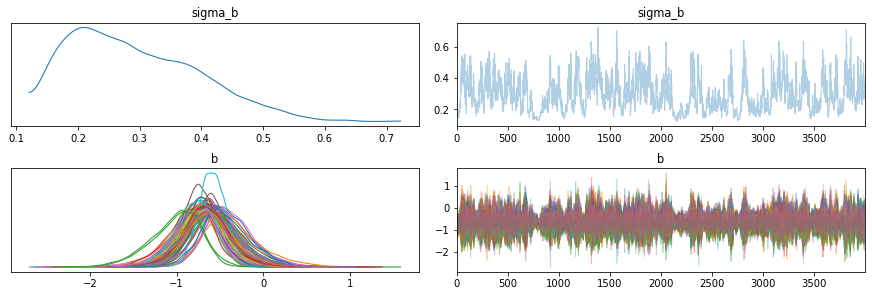

In [16]:
cp_fig = az.plot_trace(CP_trace, rug = False,divergences=None, var_names= ('sigma_b', 'b'))
fig = plt.gcf() # to get the current figure...
if True:
    fig.savefig(wd+"/figures/radon_cp_trace.pdf") # and save it directly

/home/felix/anaconda3/envs/bayesOpt/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


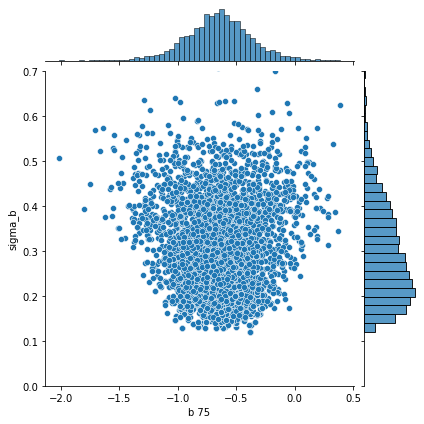

In [7]:
x = pd.Series(CP_trace['b'][:, 75], name='b 75')
y = pd.Series(CP_trace['sigma_b'], name='sigma_b')
d = pd.concat([x,y])
sns.jointplot(x, y, ylim=(0, .7));
if save_figs:
    fig.savefig(wd+"/figures/radon_cp_pairs.pdf") # and save it directly

In [8]:
with pm.Model() as NPC:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Before:
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Transformed:
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)

    # Before:
    # b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)
    # Now:
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [9]:
with NPC:
    NPC_trace = pm.sample(draws=5000, tune=1000, chains =1)[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, b_offset, a_offset, sigma_b, mu_b, sigma_a, mu_a]


Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 17 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


/home/felix/anaconda3/envs/bayesOpt/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


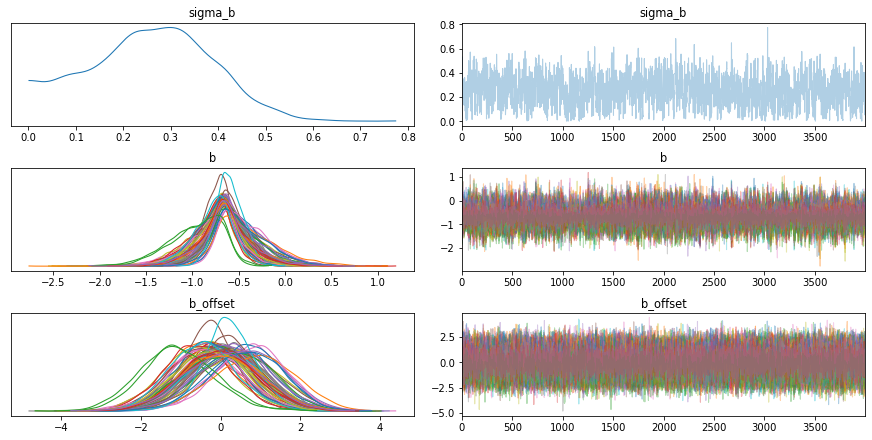

In [10]:
cp_fig = az.plot_trace(NPC_trace, rug = False,divergences=None, var_names= ('sigma_b', 'b', 'b_offset'))
fig = plt.gcf()
if save_figs:
    fig.savefig(wd+"/figures/radon_npc_trace.pdf") 

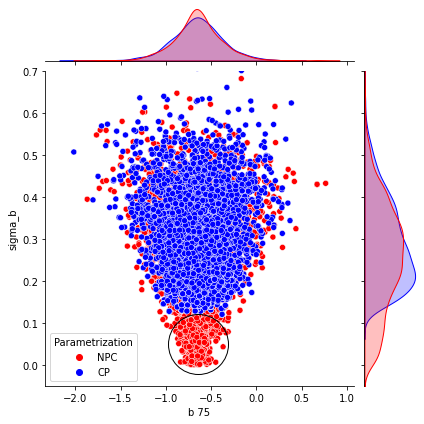

In [111]:
x1 = pd.Series(CP_trace['b'][:, 75], name='b 75')
y1 = pd.Series(CP_trace['sigma_b'], name='sigma_b')
label1 = pd.Series(["CP" for i in range(x.shape[0])], name = "Parametrization")
d1 = pd.concat([x1,y1, label1], axis = 1)

x2 = pd.Series(NPC_trace['b'][:, 75], name='b 75')
y2 = pd.Series(NPC_trace['sigma_b'], name='sigma_b')
label2 = pd.Series(["NPC" for i in range(x.shape[0])], name = "Parametrization")
d2 = pd.concat([x2,y2, label2], axis = 1)
d = pd.concat([d2,d1])


fig = sns.jointplot(data=d, x="b 75", y="sigma_b", marker = 'o',
              hue="Parametrization",palette = ['red', 'blue'], ylim= [-.05,.7])
fig.ax_joint.plot([-.65],[.05],'o',ms=60 , mec='k', mfc='none')
if save_figs:
    fig.savefig(wd+"/figures/radon_both_pairs.pdf") 